In [21]:
import numpy as np
import sys
sys.path.append('../Codebase_AGWittmann/code-base/beamtime/')
import beamtime_utils as butils
import skimage
import os
import matplotlib.pyplot as plt
import cv2
from scipy.optimize import curve_fit
from matplotlib_scalebar.scalebar import ScaleBar

In [12]:
basefolder = 'C:\\Users\\jskolaut\\Seafile\\My Library\\Beamtime_2310_MAXIV_Hematite\\Analysis\\'
basefolder = '/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/energy_images_dricorr/'
basefolderfiles = sorted(os.listdir(basefolder))

filenames = []
fileformats = []
tiffilenames = []

for i in range(len(basefolderfiles)):
    file = basefolderfiles[i]
    filenames.append(os.path.splitext(file)[0])
    fileformats.append(os.path.splitext(file)[1])
    if fileformats[i] == '.tif' or fileformats[i] == '.tiff':
        tiffilenames.append(filenames[i]+fileformats[i])
print(tiffilenames)

['Dn10_709p5_avg_dricorr.tif', 'Dn10_710p8_avg_dricorr.tif', 'Dn20_709p5_avg_dricorr.tif', 'Dn20_710p8_avg_dricorr.tif', 'Dn30_709p5_avg_dricorr.tif', 'Dn30_710p8_avg_dricorr.tif', 'Dn40_709p5_avg_dricorr.tif', 'Dn40_710p8_avg_dricorr.tif', 'Dn50_709p5_avg_dricorr.tif', 'Dn50_710p8_avg_dricorr.tif', 'Dn60_709p5_avg_dricorr.tif', 'Dn60_710p8_avg_dricorr.tif', 'Dn70_709p5_avg_dricorr.tif', 'Dn70_710p8_avg_dricorr.tif', 'Dn80_709p5_avg_dricorr.tif', 'Dn80_710p8_avg_dricorr.tif', 'Dp00_709p5_avg_dricorr.tif', 'Dp00_710p8_avg_dricorr.tif', 'Dp10_709p5_avg_dricorr.tif', 'Dp10_710p8_avg_dricorr.tif', 'Dp20_709p5_avg_dricorr.tif', 'Dp20_710p8_avg_dricorr.tif', 'Dp30_709p5_avg_dricorr.tif', 'Dp30_710p8_avg_dricorr.tif', 'Dp40_709p5_avg_dricorr.tif', 'Dp40_710p8_avg_dricorr.tif', 'Dp50_709p5_avg_dricorr.tif', 'Dp50_710p8_avg_dricorr.tif', 'Dp60_709p5_avg_dricorr.tif', 'Dp60_710p8_avg_dricorr.tif', 'Dp70_709p5_avg_dricorr.tif', 'Dp70_710p8_avg_dricorr.tif', 'Dp80_709p5_avg_dricorr.tif', 'Dp80_710

In [56]:
cut_edgepx_i = 180
cut_edgepx_j = 180

nrangles = int(len(tiffilenames)/2)
imageshape= np.shape(butils.read_tiff(basefolder+tiffilenames[0]))
print(imageshape)
imagepxnr_i = imageshape[0]-2*cut_edgepx_i
imagepxnr_j = imageshape[1]-2*cut_edgepx_j
xmld_stack = np.zeros((nrangles, imagepxnr_i, imagepxnr_j))
xmld_stack_corrected = np.zeros_like(xmld_stack)


for i in range(nrangles):
    lo_energy_im = butils.read_tiff(basefolder+tiffilenames[2*i])[cut_edgepx_i:-1*cut_edgepx_i,cut_edgepx_j:-1*cut_edgepx_j]
    hi_energy_im = butils.read_tiff(basefolder+tiffilenames[2*i+1])[cut_edgepx_i:-1*cut_edgepx_i,cut_edgepx_j:-1*cut_edgepx_j]
    #xmld_stack[i] = butils.get_xmld(lo_energy_im,hi_energy_im)   
    #xmld_stack[i] = lo_energy_im-hi_energy_im #/(lo_energy_im+hi_energy_im)
    xmld_stack[i] = lo_energy_im/hi_energy_im
    #xmld_stack_corrected[i] = butils.readjust_contrast(xmld_stack_corrected[i])
    xmld_stack_corrected[i] = butils.remove_polynomial_background(xmld_stack[i],n=1,small_size=imagepxnr_i)
    xmld_stack_corrected[i] = butils.readjust_contrast(xmld_stack_corrected[i])
    
print(np.shape(xmld_stack))

angles = np.zeros(nrangles)
for i in range(nrangles):
    if filenames[2*i][1] == 'n':
        angles[i] = -1 * int(filenames[2*i][2:4])
    if filenames[2*i][1] == 'p':
        angles[i] = int(filenames[2*i][2:4])

angles[0:8] = np.flip(angles[0:8])
xmld_stack_corrected[0:8,:,:] = np.flip(xmld_stack_corrected[0:8,:,:],axis=0)

resize = (128,128)
ang_fit, ang_fit_err, amp_fit, img_pixavg = butils.get_vector_map(xmld_stack_corrected,angles,resize=resize)


print('Done')


(1024, 1024)
(18, 664, 664)
Done


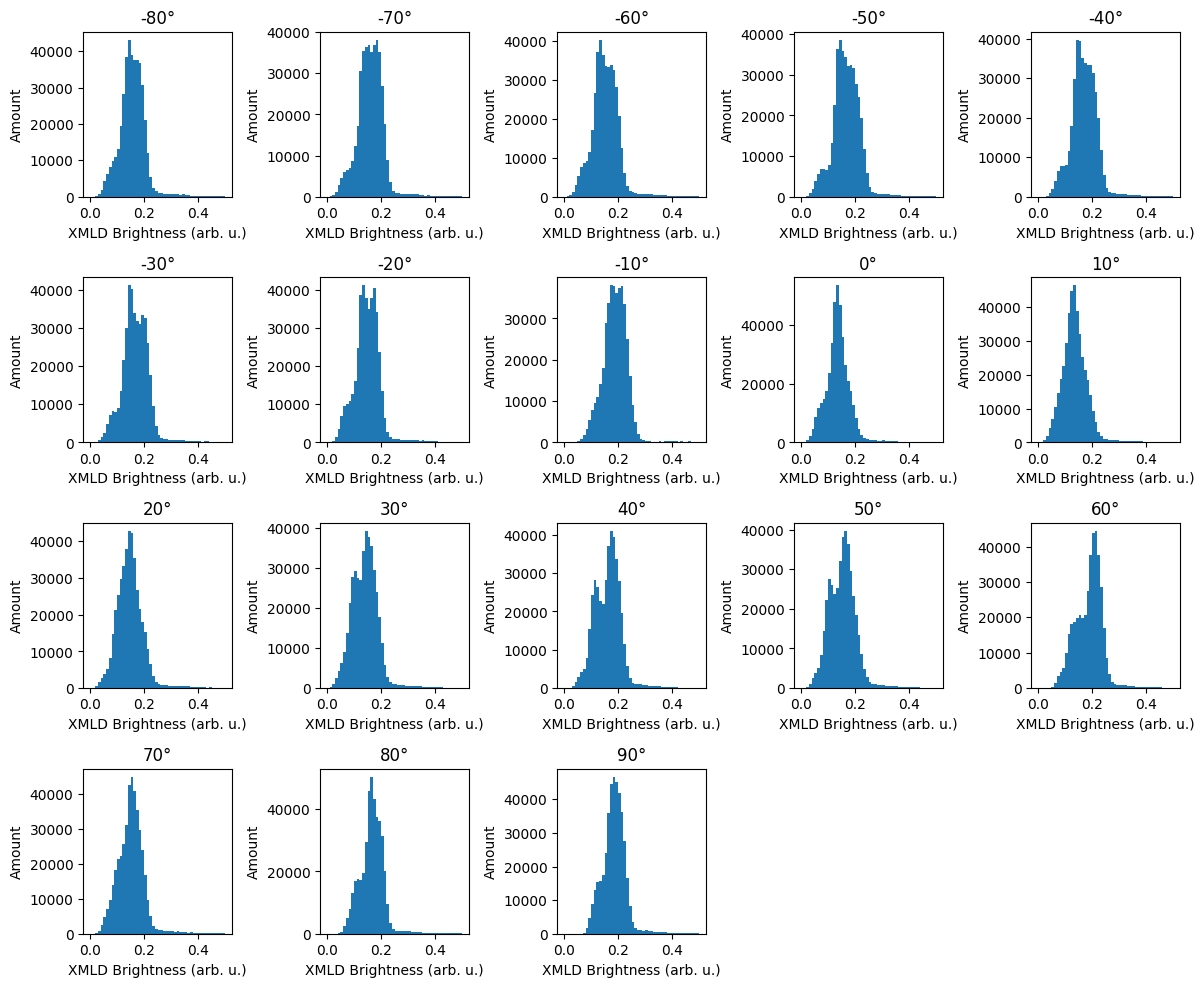

In [58]:
xmld_forhist = np.zeros_like(xmld_stack_corrected)
for i in range(xmld_forhist_shape[0]):
    for j in range(xmld_forhist_shape[1]):
        for k in range(xmld_forhist_shape[2]):
            xmld_forhist[i,j,k] = xmld_stack_corrected[i,j,k]
xmld_forhist_shape = np.shape(xmld_forhist)
for i in range(xmld_forhist_shape[0]):
    for j in range(xmld_forhist_shape[1]):
        for k in range(xmld_forhist_shape[2]):
            if xmld_forhist[i,j,k] > 0.5:
                xmld_forhist[i,j,k] = float('NaN')
 
fig = plt.figure(figsize=(12,12))
for i in range(nrangles):
    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
    ax_temp.set_title(str(int(angles[i]))+'°')
    ax_temp.hist(xmld_forhist[i].ravel(), bins = 50)
    ax_temp.set_xlabel('XMLD Brightness (arb. u.)')
    ax_temp.set_ylabel('Amount')

fig.tight_layout()
fig.savefig('/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/Histograms_corrected_cutoff.png',dpi=120)#,transparent=True)


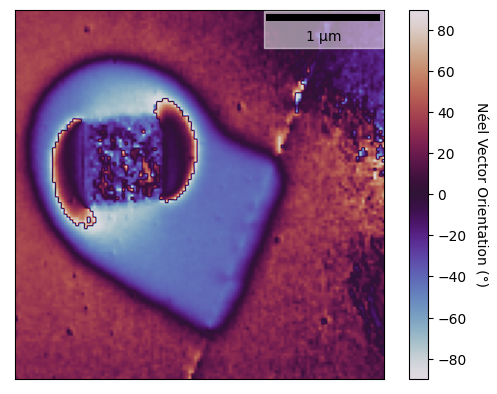

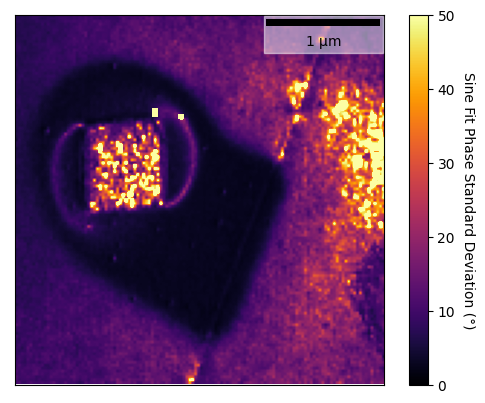

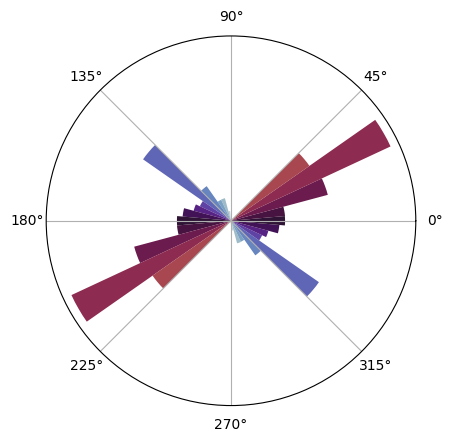

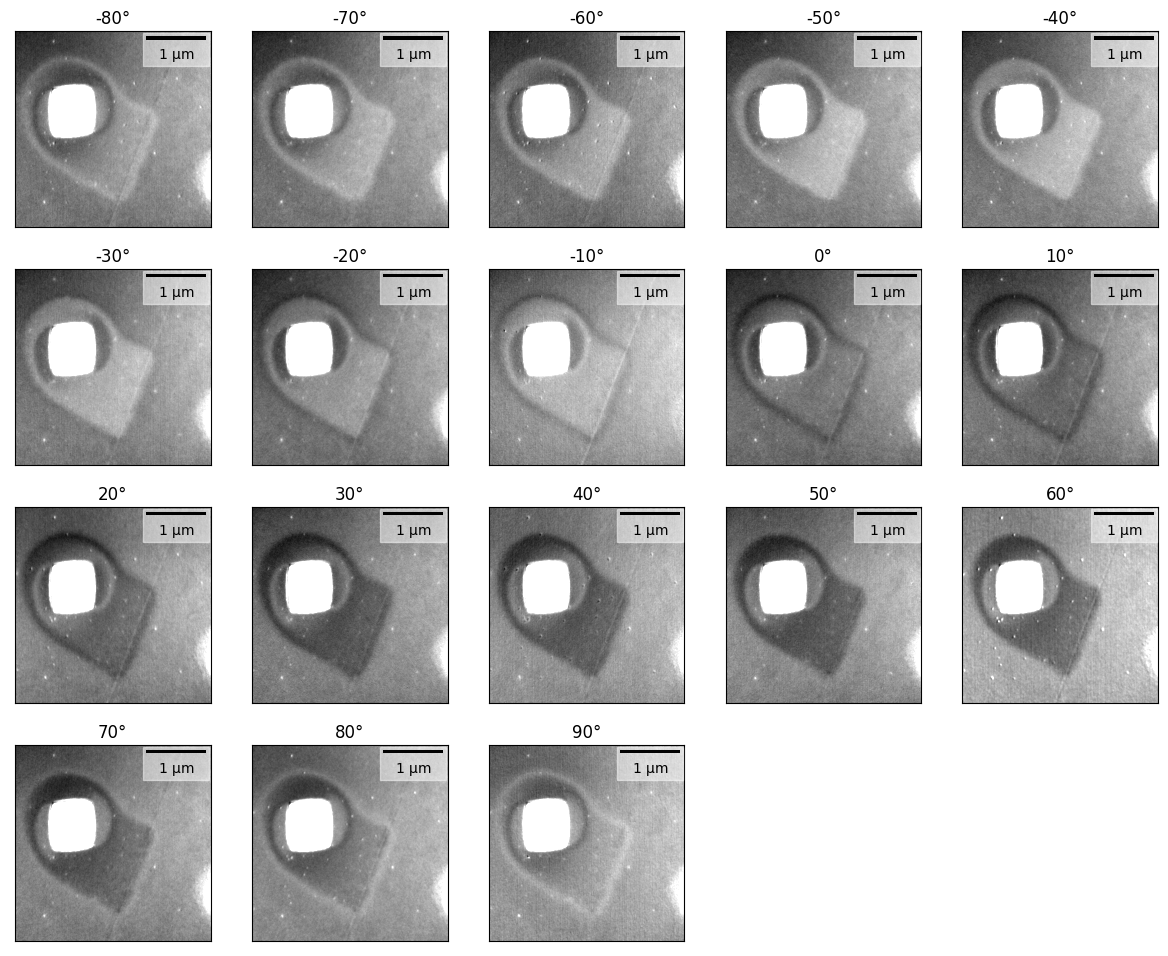

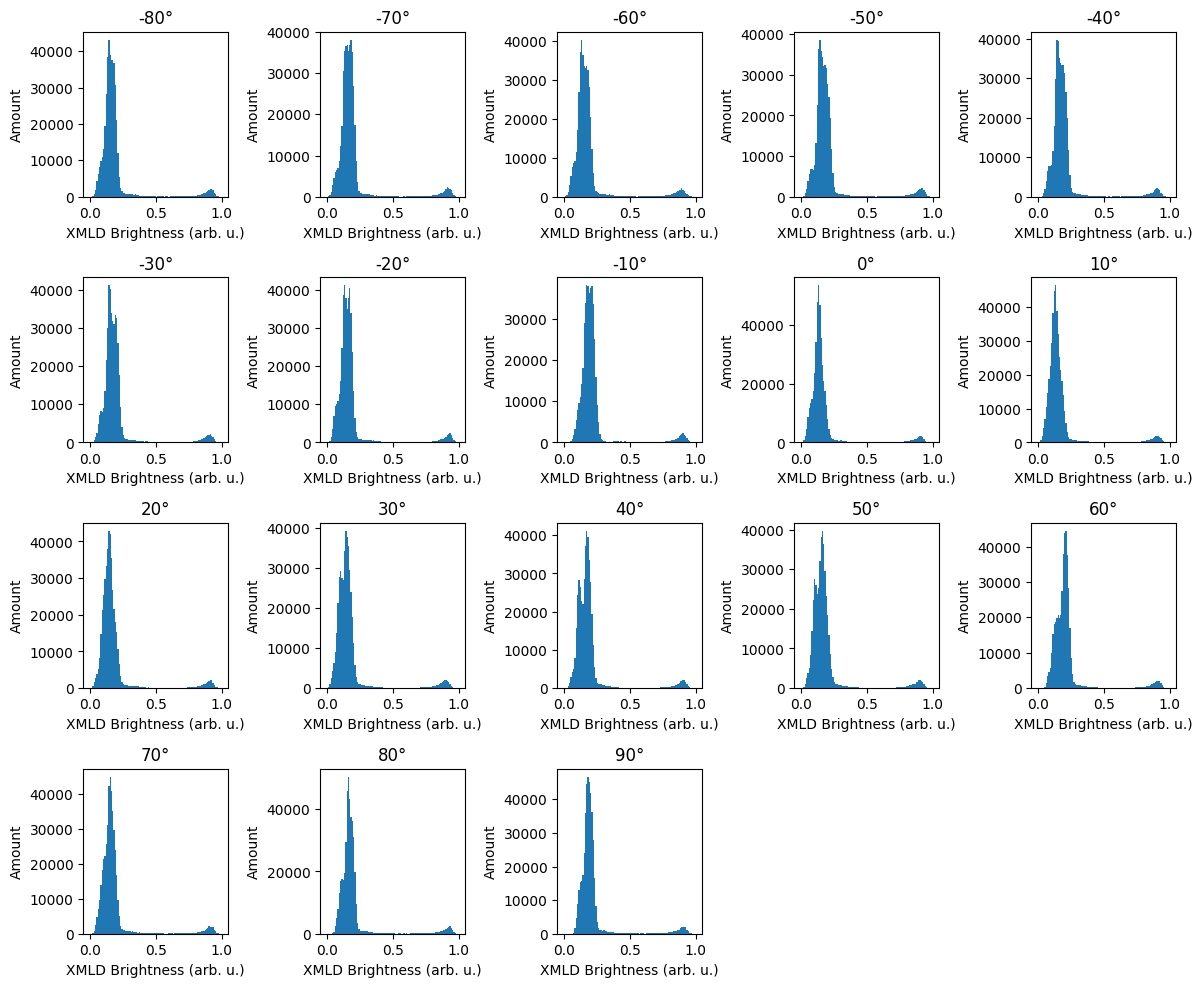

In [61]:
cm = 'twilight'
actualsize = 5*1e-6
resolution =1024
vmap_px_fac = 1/(resize[0]/(resolution-2*cut_edgepx_i))

fig, ax = plt.subplots()
im = ax.imshow(ang_fit, cmap=cm, vmin=-90, vmax=90)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
cb = fig.colorbar(im)
cb.set_label('Néel Vector Orientation (°)',rotation=270,labelpad=15)
vmap_scalebar=ScaleBar(actualsize/resolution*vmap_px_fac, length_fraction=0.5, width_fraction=0.02, box_alpha=0.5,frameon=True,box_color='w')#,font_properties={'size':15})
ax.add_artist(vmap_scalebar)

fig.savefig('/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/TIE_square_VMap.png',dpi=300,bbox_inches='tight')


fig, ax = plt.subplots()
im = ax.imshow(ang_fit_err, cmap='inferno', vmin=0, vmax=50)
cb = fig.colorbar(im)
cb.set_label('Sine Fit Phase Standard Deviation (°)',rotation=270,labelpad=15)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
vmap_err_scalebar=ScaleBar(actualsize/resolution*vmap_px_fac, length_fraction=0.5, width_fraction=0.02, box_alpha=0.5,frameon=True,box_color='w')#,font_properties={'size':15})
ax.add_artist(vmap_err_scalebar)

fig.savefig('/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/TIE_square_VMap_Errors.png',dpi=300,bbox_inches='tight')


fig8, ax8 = plt.subplots(subplot_kw=dict(projection='polar'))
ang_rav_cut = ang_fit[np.where(ang_fit_err < 15)]
#shift bins:
x = ang_rav_cut.copy()
x = np.where(x<-85,x+180,x)
bins = 18
b,c = np.histogram(x,bins=bins)
ca = c[0:-1] + np.diff(c)[0]/2+90
cmap = plt.cm.get_cmap(cm)
colors = cmap((ca)/180)
ax8 = plt.subplot(111, polar=True)
ax8.bar(np.deg2rad(ca)+1/2*np.pi,b,color=colors,width=np.pi/bins)
ax8.bar(np.deg2rad(ca)-1/2*np.pi,b[:],color=colors,width=np.pi/bins)
ax8.axes.yaxis.set_visible(False)

fig8.savefig('/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/TIE_square_VMap_AngHist.png',dpi=300,bbox_inches='tight')


fig = plt.figure(figsize=(12,12))
for i in range(nrangles):
    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
    ax_temp.imshow(xmld_stack_corrected[i],cmap='gray', vmin = 0, vmax = 0.3)
    ax_temp.set_title(str(int(angles[i]))+'°')
    ax_temp.get_xaxis().set_visible(False)
    ax_temp.get_yaxis().set_visible(False)
    xmld_corr_scalebar=ScaleBar(actualsize/resolution, length_fraction=0.5, width_fraction=0.02, box_alpha=0.5,frameon=True,box_color='w')#,font_properties={'size':15})
    ax_temp.add_artist(xmld_corr_scalebar)

fig.tight_layout()
fig.savefig('/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/XMLDs_AngResolved.png',dpi=120)#,transparent=True)


fig = plt.figure(figsize=(12,12))
for i in range(nrangles):
    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
    ax_temp.hist(xmld_stack_corrected[i].ravel(), bins = 100)
    ax_temp.set_title(str(int(angles[i]))+'°')
    ax_temp.set_xlabel('XMLD Brightness (arb. u.)')
    ax_temp.set_ylabel('Amount')

fig.tight_layout()
fig.savefig('/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/Histograms_corrected.png',dpi=120)#,transparent=True)


#fig = plt.figure(figsize=(12,12))
#for i in range(nrangles):
#    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
#    ax_temp.imshow(xmld_stack[i],cmap='gray')#,vmax = 5)

#fig = plt.figure(figsize=(12,12))
#for i in range(nrangles):
#    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
#    ax_temp.hist(xmld_stack[i].ravel(), bins = 100)




In [ ]:

def sin2(x,theta,A,offset):
    return np.sin(np.deg2rad(x+theta))**2*A+offset

img_pixavg = np.array([
        skimage.transform.resize(image, resize) for image in xmld_stack_corrected])

for i in range(resize[0]):
    for j in range(resize[1]):
        if i+j == 5*j:
            intensity = img_pixavg[:,i,j]
            try:
                boundary = ([-90, 0, -np.inf],[90, np.inf, np.inf])
                popt, pcov = curve_fit(sin2, angles, intensity, bounds=boundary)
                perr = np.sqrt(np.diag(pcov))
            except: 
                popt = np.ones(3)*np.nan
                perr = np.ones(3)*100
    
            fig0,ax0 = plt.subplots()
            print(*popt)
            ax0.plot(angles,intensity,color='C1',marker='o',lw=0)
            ax0.plot(np.linspace(-90,90,100),sin2(np.linspace(-90,90,100),*popt))
            ax0.set_xlabel('Polarization angle (°)')
            ax0.set_ylabel('XMLD (arb. u.)')
            



In [ ]:
imagepath1= (basefolder+tiffilenames[1])
#image1 = cv2.cvtColor(basefolder+tiffilenames[0])
image1 = butils.read_tiff(imagepath1)#[256:-256,256:-256]
plt.imshow(image1, cmap = 'gray')#, vmin=-30,vmax= 35)
plt.show()
image1_bkgcorr = butils.slightly_smarter_background_correction(image1,n=2,edge_cutting_condition_factor=0.95)
image1_bkgcorr_norm = (image1_bkgcorr-np.min(image1_bkgcorr))/(np.max(image1_bkgcorr)-np.min(image1_bkgcorr))
print(np.max(image1_bkgcorr_norm),np.min(image1_bkgcorr_norm),np.shape(image1))
#plt.imshow(image1, vmin=80,vmax= 100)
plt.imshow(image1_bkgcorr_norm[50:-50,50:-50], cmap = 'gray')#, vmin=-30,vmax= 35)
plt.show()

imagepath2= (basefolder+tiffilenames[2])
#image1 = cv2.cvtColor(basefolder+tiffilenames[0])
image2 = butils.read_tiff(imagepath2)
image2_bkgcorr = butils.slightly_smarter_background_correction(image2,n=2,edge_cutting_condition_factor=0.95)
image2_bkgcorr_norm = (image2_bkgcorr-np.min(image2_bkgcorr))/(np.max(image2_bkgcorr)-np.min(image2_bkgcorr))
print(np.max(image2_bkgcorr_norm),np.min(image2_bkgcorr_norm))
#plt.imshow(image2, vmin=80,vmax= 100)
plt.imshow(image2_bkgcorr_norm[50:-50,50:-50], cmap = 'gray')#, vmin=-30,vmax= 35)
plt.show()
